In [12]:
import os
import sys
import argparse
from collections import OrderedDict
from collections import OrderedDict as OD
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib

sys.path.insert(1, '../l1JetLayer2Calibration_usingBDT')
from CommonTools import (
    convert_CaloToolMPEta_to_IEta, map_CaloIEta_to_CaloTool_mpEta
)


sipFileJECLUTs_dict = {
    '2023': {
        'LUTJEC': '/afs/cern.ch/work/s/ssawant/private/L1T_ServiceTasks/hcalPUsub_v7_20240209/JEC_2024_round1/CMSSW_15_0_2/src/L1Trigger/L1TCalorimeter/data/lut_calib_2023v0_ECALZS_PhiRing.txt',
        'LUTPt':  '/afs/cern.ch/work/s/ssawant/private/L1T_ServiceTasks/hcalPUsub_v7_20240209/JEC_2024_round1/CMSSW_15_0_2/src/L1Trigger/L1TCalorimeter/data/lut_pt_compress_2017v1.txt',
        'LUTEta': '/afs/cern.ch/work/s/ssawant/private/L1T_ServiceTasks/hcalPUsub_v7_20240209/JEC_2024_round1/CMSSW_15_0_2/src/L1Trigger/L1TCalorimeter/data/lut_eta_compress_2017v1.txt'
    },
    '2024 conservative': {
        'LUTJEC': '/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/ddharmen/LUTs_conservative/lut_calib_ConservativeZS.txt',
        'LUTPt':  '/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/ddharmen/LUTs_conservative/lut_pt_compress_ConservativeZS.txt',
        'LUTEta': '/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/ddharmen/LUTs_conservative/lut_eta_compress_ConservativeZS.txt'
    },
    
}

sOutDir = "plots_compareJECLUTS"

PT_Bins = range(15,256)

useAbsEtaBins = True
ETA_Bins = []
for iEta in range(-41,42):
    if iEta in [-29, 0, 29]:        continue;
    if useAbsEtaBins and iEta < 0:  continue;
    ETA_Bins.append(str(iEta))


In [13]:
class LUT:
    def __init__(self, sipFileLUT):
        with open(sipFileLUT) as f:
            self.data_dict = {}
            for line in f:
                line = line.strip().split(' ')
                if '#<header>' in line[0]: # header line                    
                    self.nrBitsAddress = int(line[2])
                    self.nrBitsData    = int(line[3])
                if '#' in line[0]: # comment line
                    continue
                
                self.data_dict[int(line[0])] = int(line[1])

    def data(self, bin):
        return self.data_dict[bin]

In [14]:
JECSFs = {}
for Pt in PT_Bins:
    JECSFs[Pt] = {}
    for Eta in ETA_Bins:
        Eta = int(Eta)
        JECSFs[Pt][Eta] = {}
        for sJECName, JECLUTdict in sipFileJECLUTs_dict.items():
            lutJEC = LUT(JECLUTdict['LUTJEC'])
            lutPt  = LUT(JECLUTdict['LUTPt'])
            lutEta = LUT(JECLUTdict['LUTEta'])

            Hwpt = Pt * 2 # Hardware pT is double of pT in GeV units

            # Read JEC LUTs and do JEC as in CMSSW
            # Reading JEC LUTs in cmssw: https://github.com/cms-sw/cmssw/blob/master/L1Trigger/L1TCalorimeter/src/firmware/Stage2Layer2JetAlgorithmFirmwareImp1.cc#L691
            ptCompNrBits = lutPt.nrBitsData
            ptBin = lutPt.data(Hwpt >> 1)
            etaBin = lutEta.data( map_CaloIEta_to_CaloTool_mpEta[abs(Eta)] )
            compBin = (etaBin << ptCompNrBits) | ptBin;

            addPlusMult = lutJEC.data(compBin)
            multiplier = addPlusMult & 0x3ff;
            addend = (addPlusMult >> 10);
            jetPtCorr = ((Hwpt * multiplier) >> 9) + addend;
            JECSF = float(jetPtCorr) / float(Hwpt)

            #print(f"{Pt = }, {Eta = }, {Hwpt = }, {map_CaloIEta_to_CaloTool_mpEta[abs(Eta)] = }, {ptCompNrBits = }, {ptBin = }, {etaBin = }, {compBin = }, {addPlusMult = }, {multiplier = }, {addend = }, {jetPtCorr = }, {JECSF = }")
            JECSFs[Pt][Eta][sJECName] = JECSF

/tmp/ssawant/ipykernel_4047430/2744394211.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')


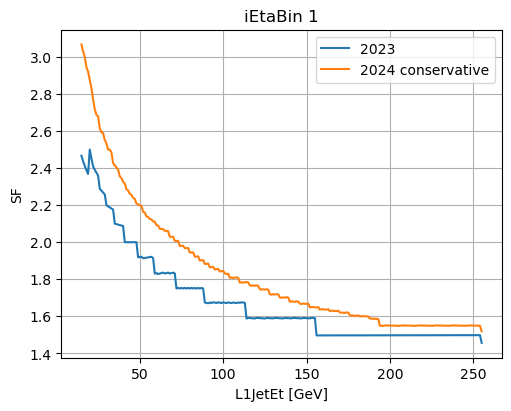

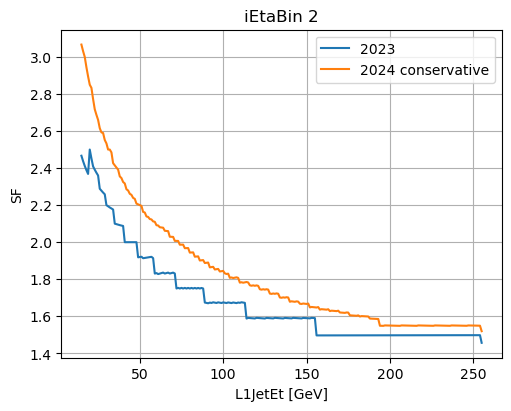

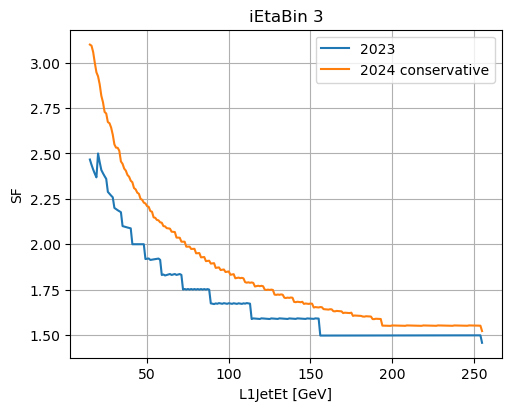

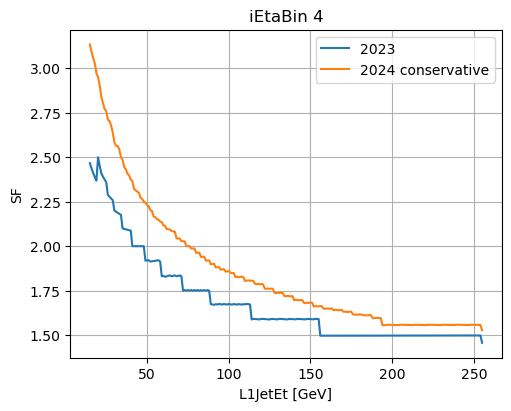

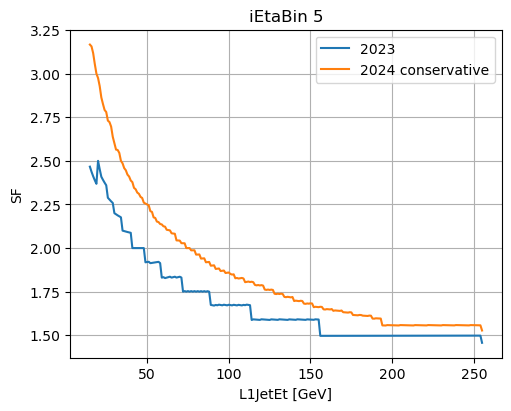

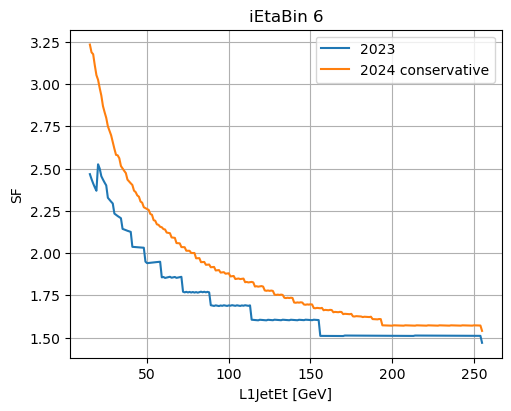

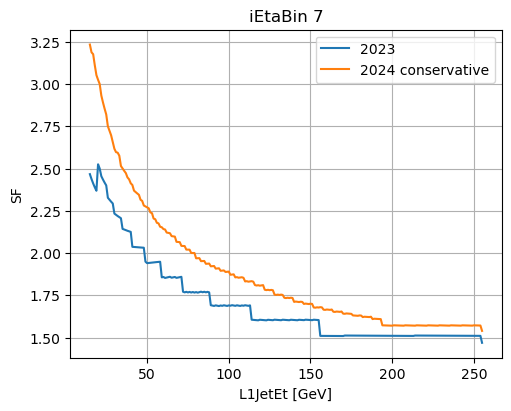

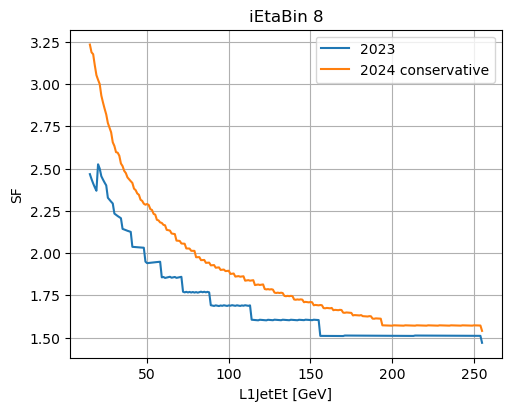

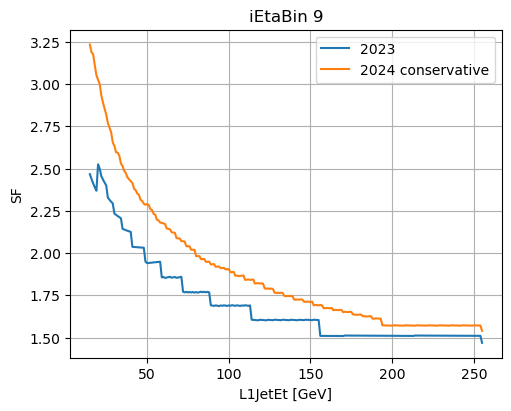

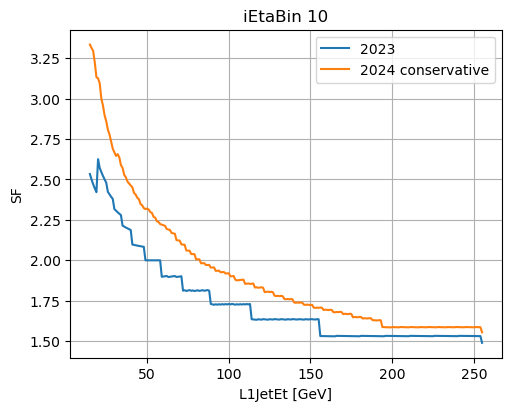

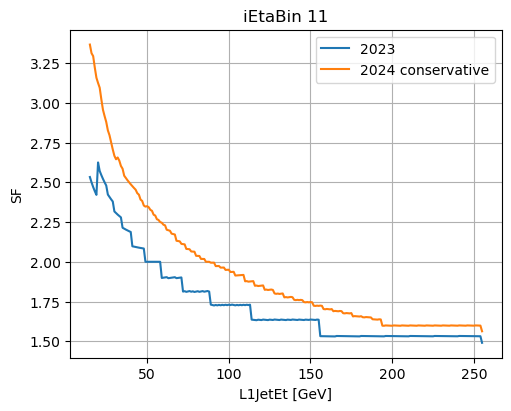

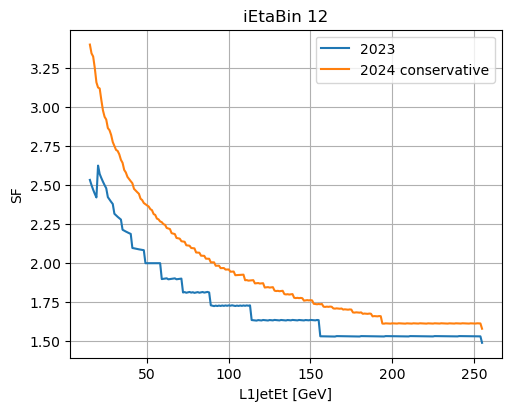

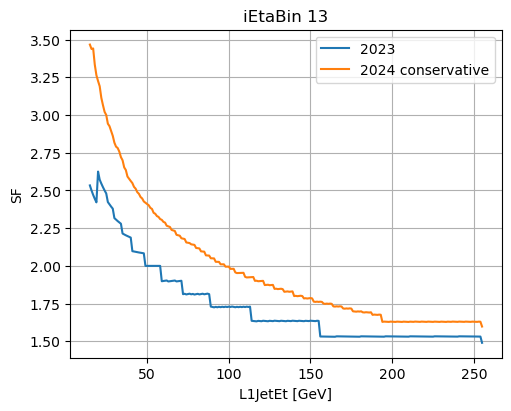

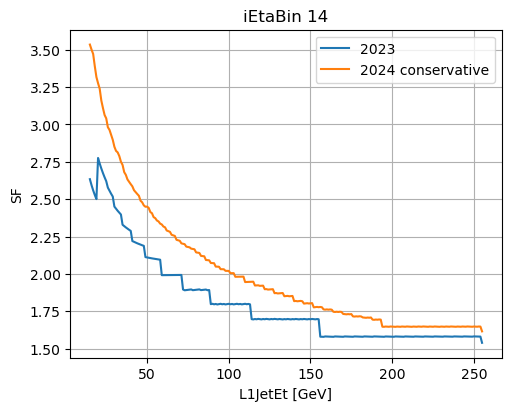

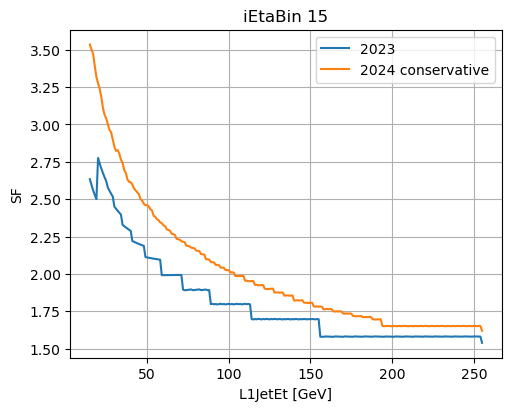

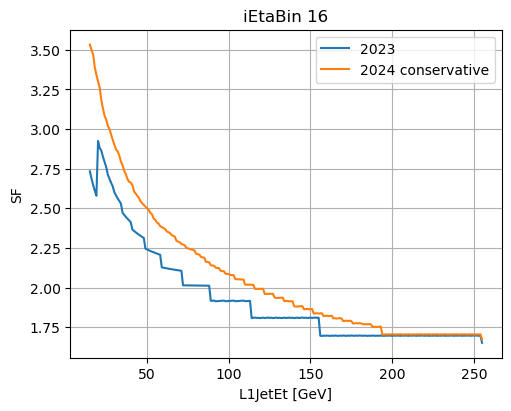

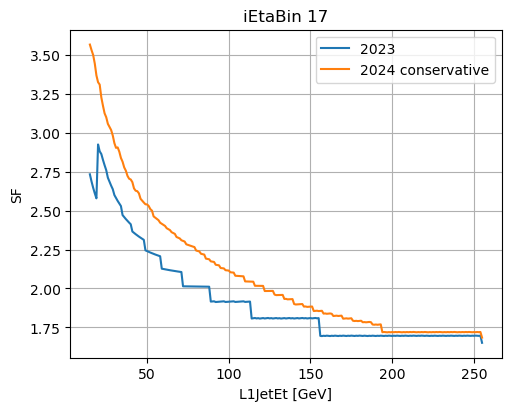

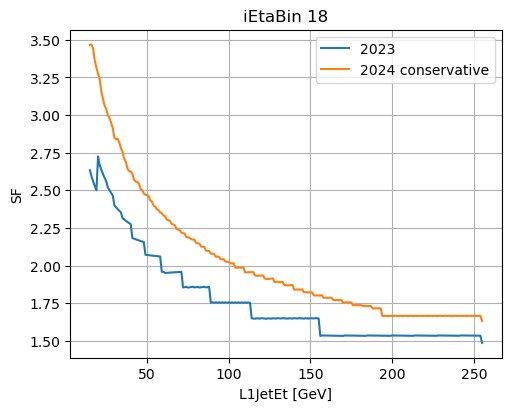

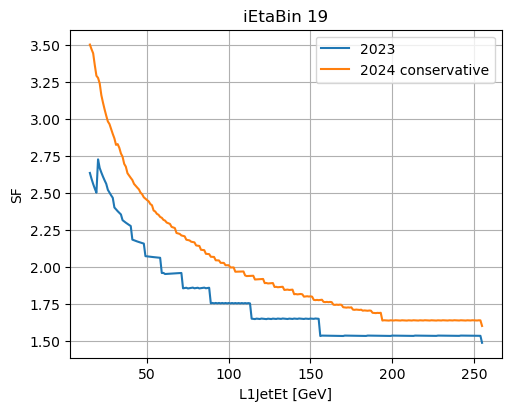

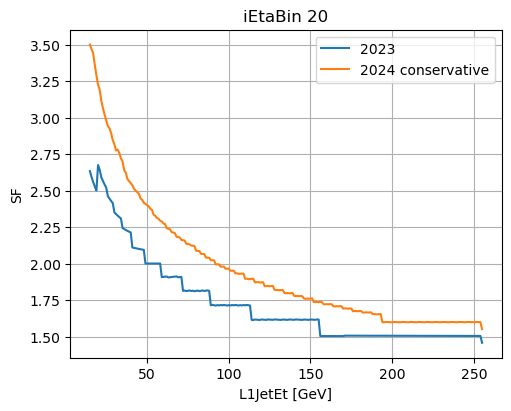

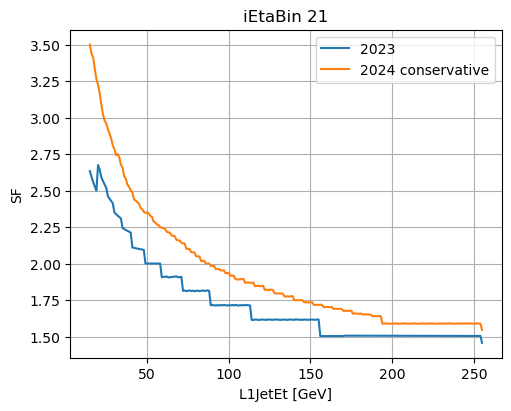

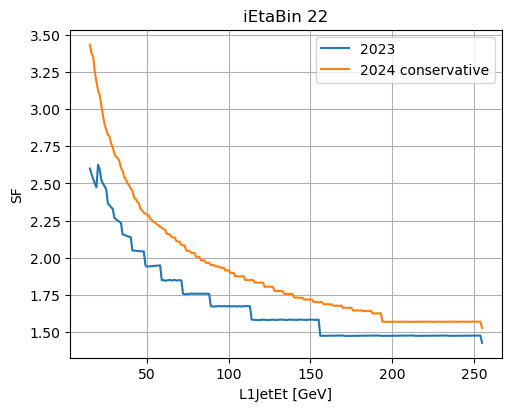

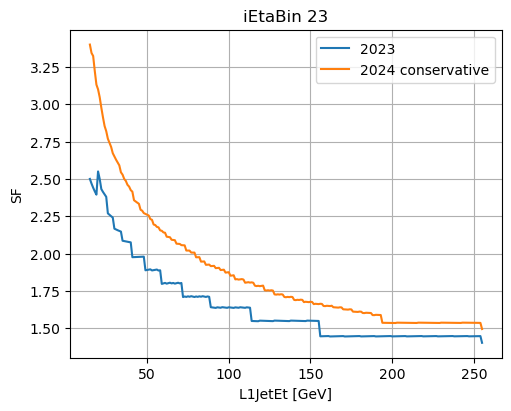

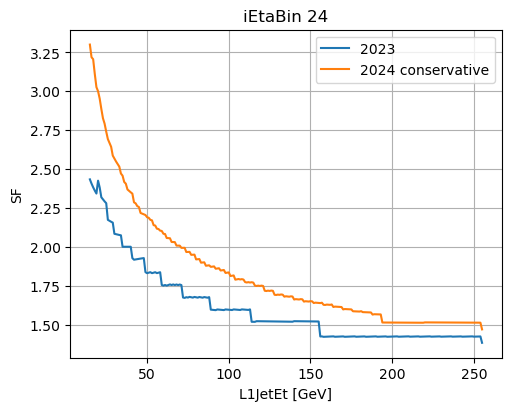

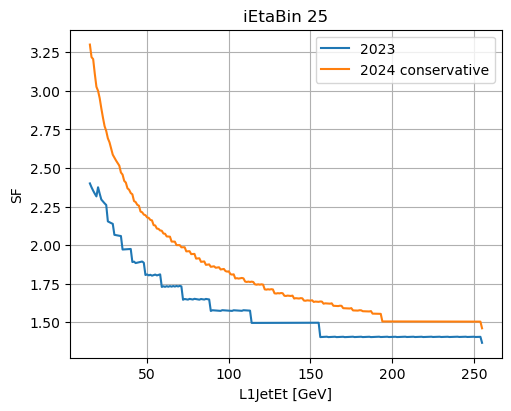

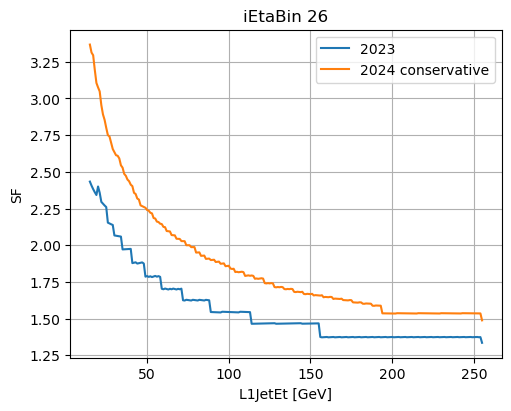

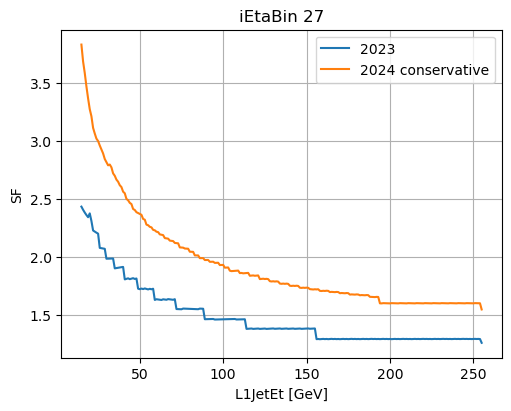

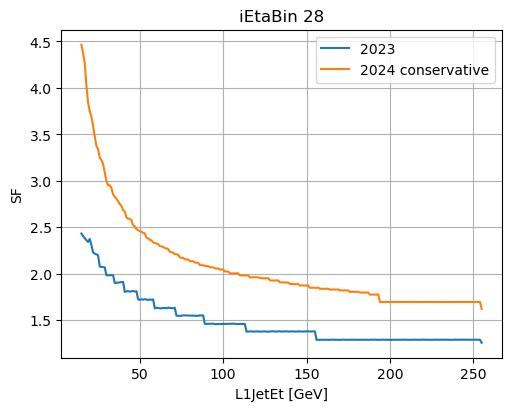

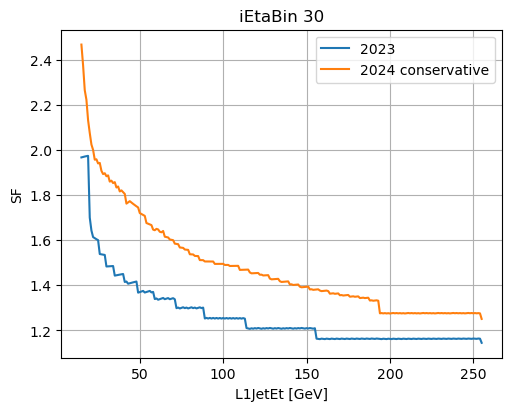

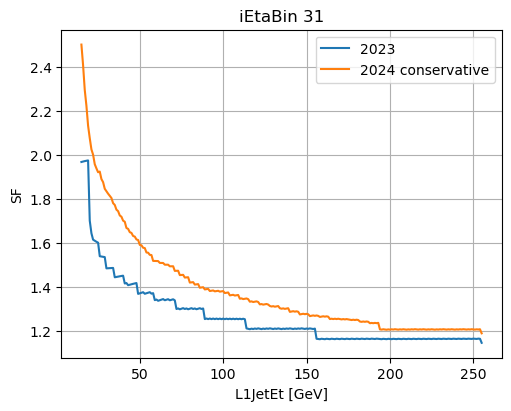

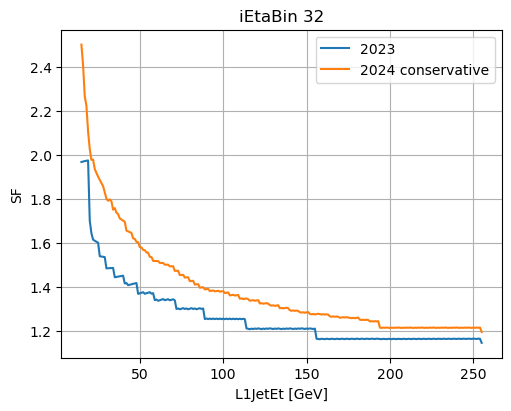

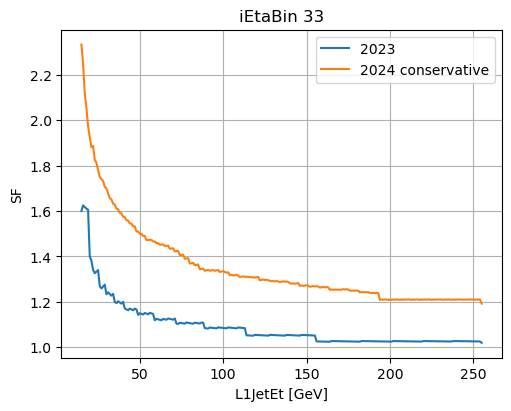

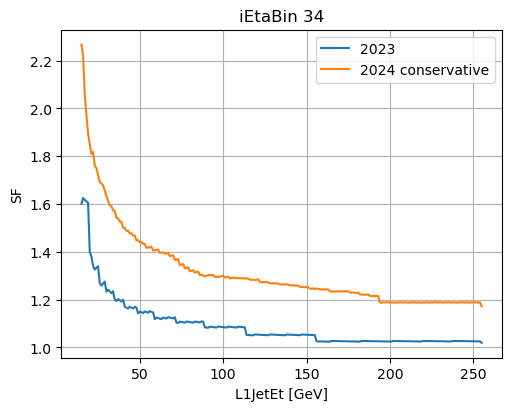

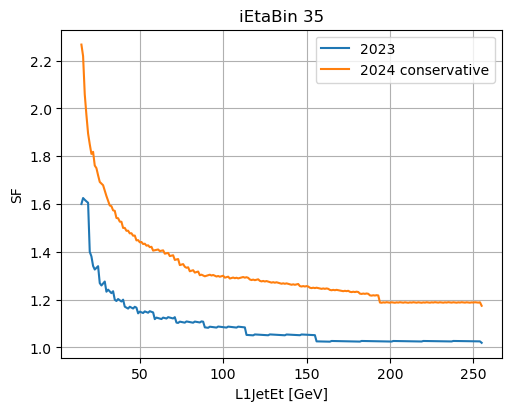

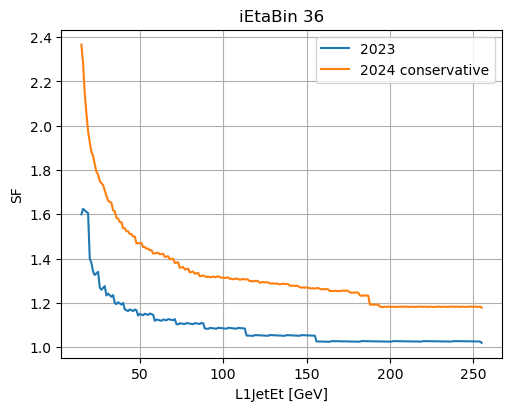

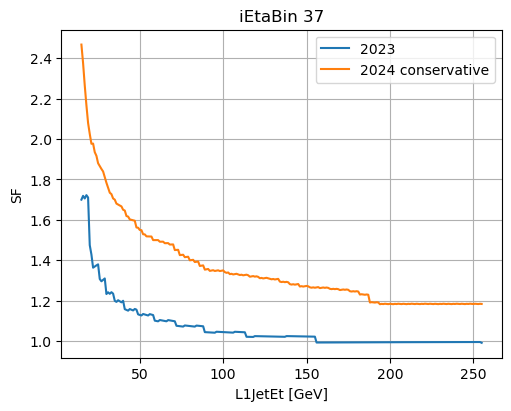

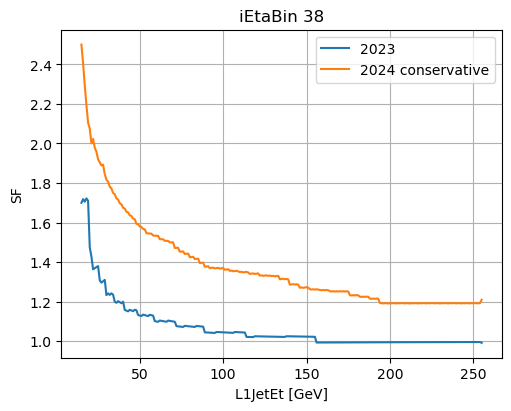

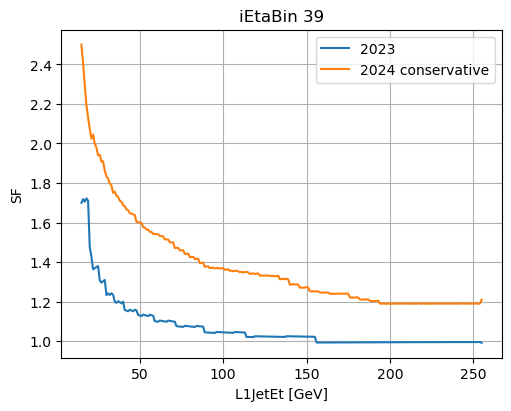

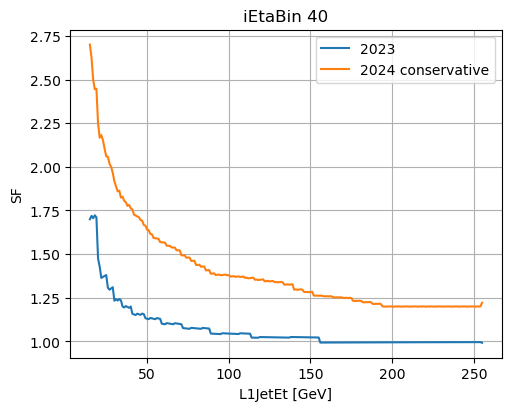

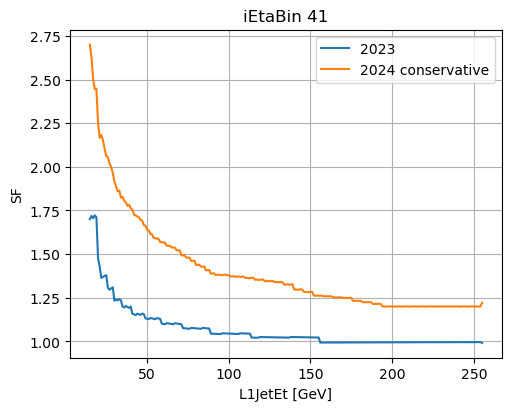

In [15]:
# plot SFs -----------------------------------
sOutDir_toUse = '%s/SFs' % (sOutDir)
os.makedirs(sOutDir_toUse, exist_ok=True )

for Eta in ETA_Bins:
    Eta = int(Eta)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  

    for sJECName in sipFileJECLUTs_dict.keys():
        JECSFs_ = [JECSFs[Pt][Eta][sJECName] for Pt in PT_Bins]

        axs.plot(PT_Bins, JECSFs_, label=sJECName)

    axs.set_xlabel('L1JetEt [GeV]')                 
    axs.set_ylabel('SF')
    axs.set_title('iEtaBin %d' % (Eta))
    axs.grid()
    axs.legend()
        
    fig.savefig('%s/compareJECLUTs_iEta%d.png' % (sOutDir_toUse, Eta))

